In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

import seaborn as sns
sns.set(color_codes=True)

from pymongo import MongoClient
cl = MongoClient()
db = cl['flights']
col = db['adsb_flights']

<h2>Distribution of CTE over time</h2>
Based on the collection of nominal projections, the Cross-Track error at a specified look-ahead time are aggregated and plotted

In [5]:
# create bin dataframe
la_time = 900
bin_sec = 20
bin_dp_df = {}

for f in db['projected_flights'].find()[:300]:
    f = pd.DataFrame.from_dict(f)
    for b in range(int(la_time/bin_sec)):
        bmin = b*bin_sec
        bmax = (b+1)*bin_sec
        if str(bmax)+'_cte' not in list(bin_dp_df.keys()):
            bin_dp_df[str(bmax)+'_cte'] = []
        if str(bmax)+'_ate' not in list(bin_dp_df.keys()):
            bin_dp_df[str(bmax)+'_ate'] = []
        if str(bmax)+'_tte' not in list(bin_dp_df.keys()):
            bin_dp_df[str(bmax)+'_tte'] = []
            
        bin_dp_df[str(bmax)+'_cte'].extend(f['cte'][(f['time_proj'] >= bmin) & (f['time_proj'] <= bmax)])
        bin_dp_df[str(bmax)+'_tte'].extend(f['tte'][(f['time_proj'] >= bmin) & (f['time_proj'] <= bmax)])
        bin_dp_df[str(bmax)+'_ate'].extend(f['ate'][(f['time_proj'] >= bmin) & (f['time_proj'] <= bmax)])

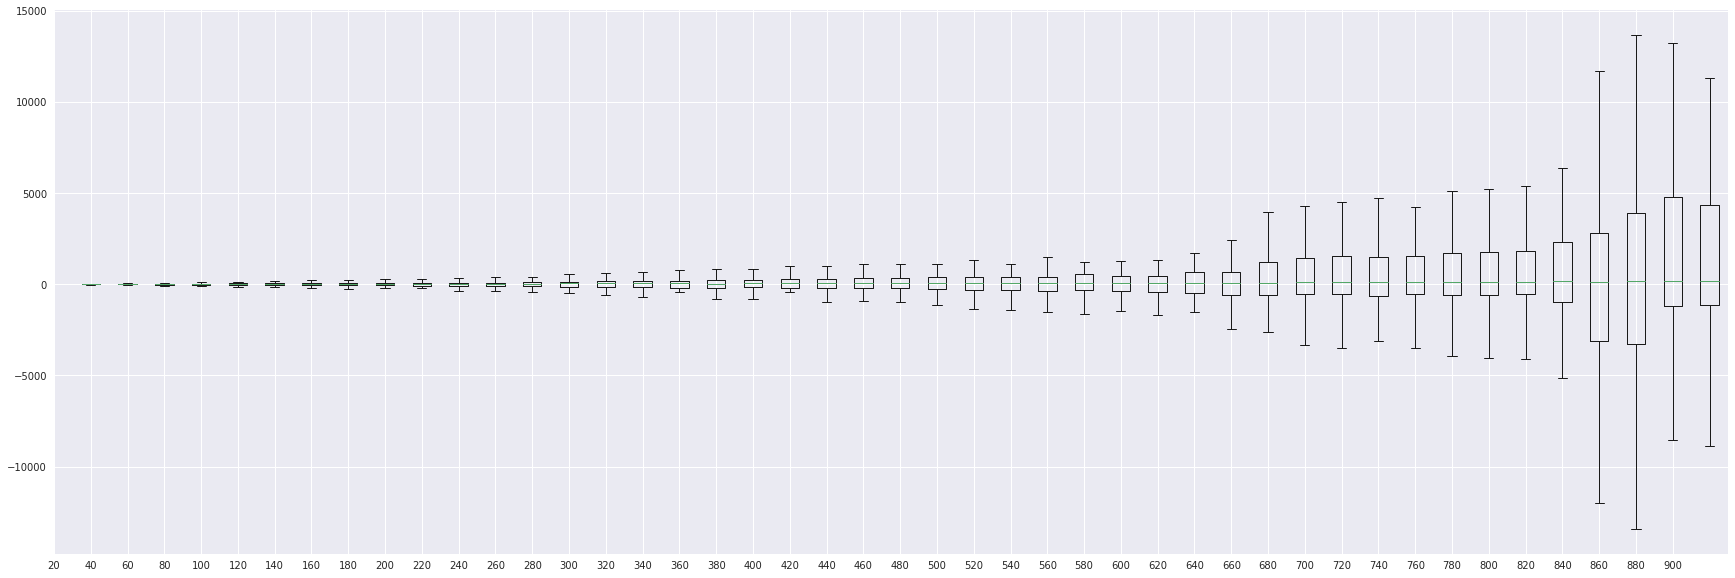

In [6]:
box_data = []

bin_df = bin_dp_df #set type of error (cp or d)

for k in bin_df.keys():
    if '_cte' in k:
        box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))
plt.figure(figsize=(30,10))
plt.boxplot(box_data_2, showfliers=False)
plt.xticks(x, [i[0] for i in box_data_sort])
plt.show()

<h2> 2D distribution of CTE and ATE at a specified look-ahead time</h2>
For a specified look-ahead time, a two dimensional distribution is plotted incorporating CTE and ATE. 

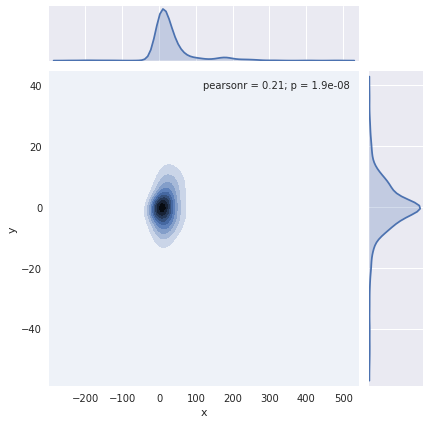

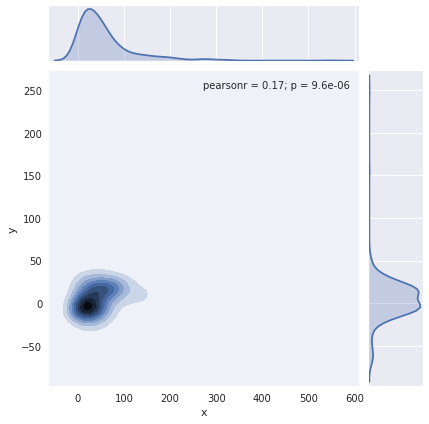

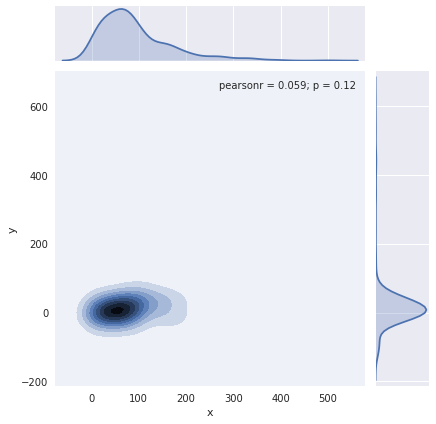

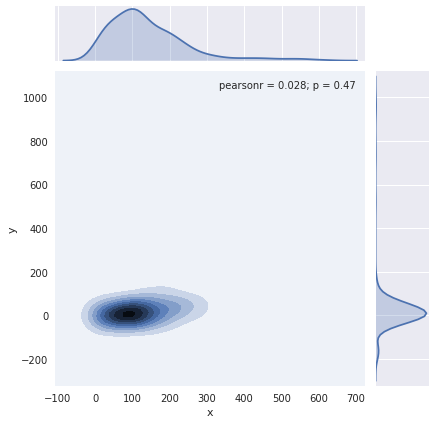

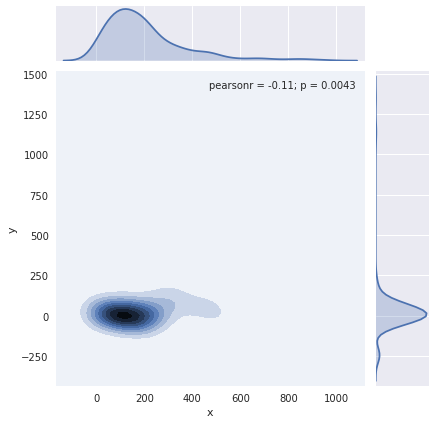

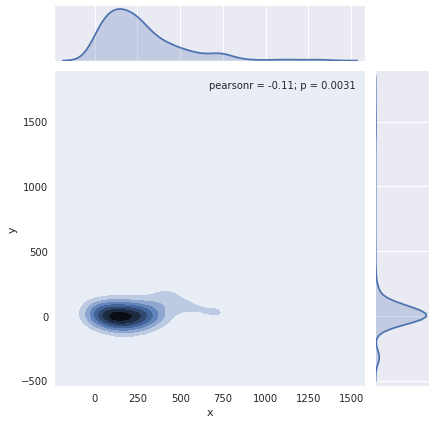

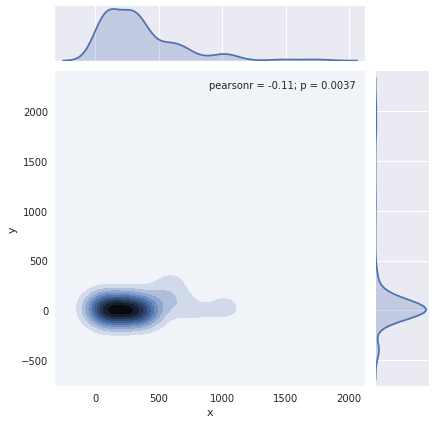

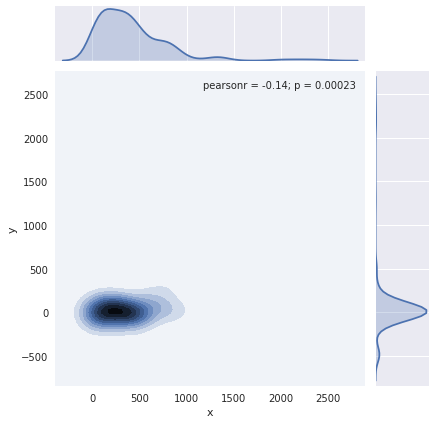

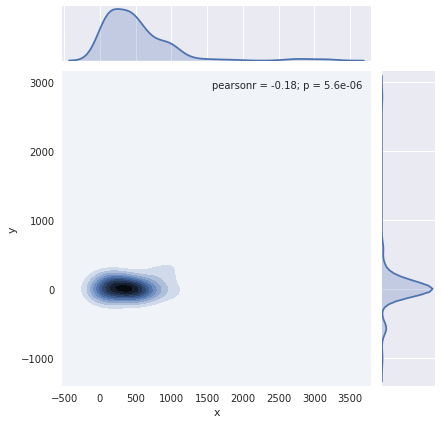

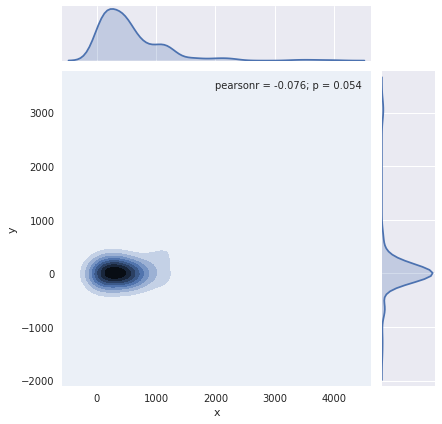

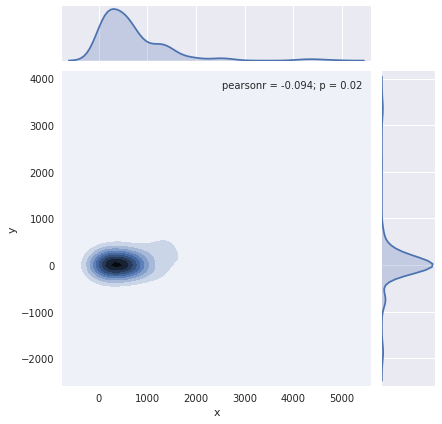

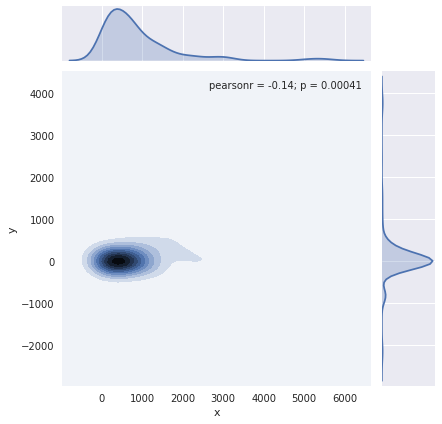

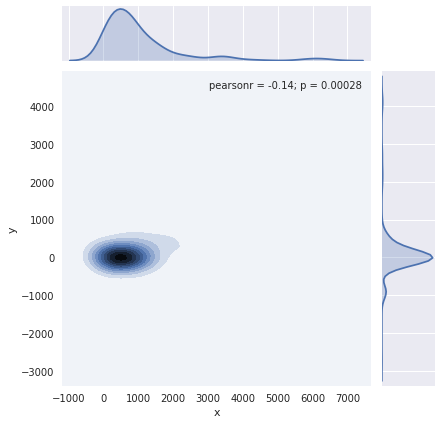

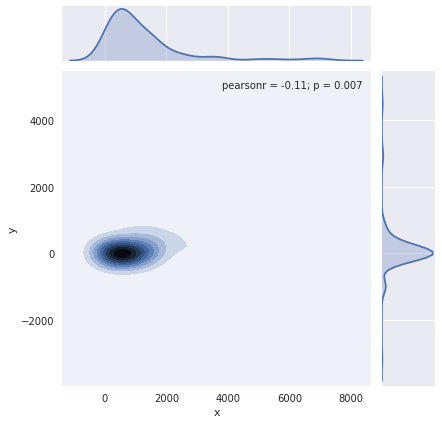

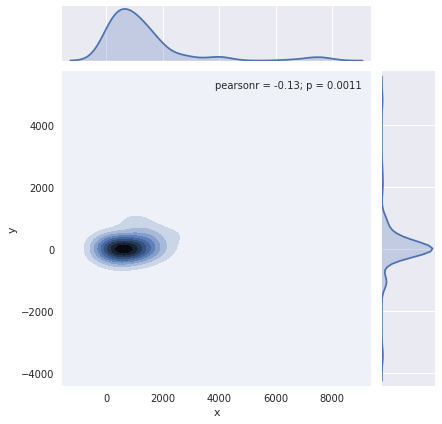

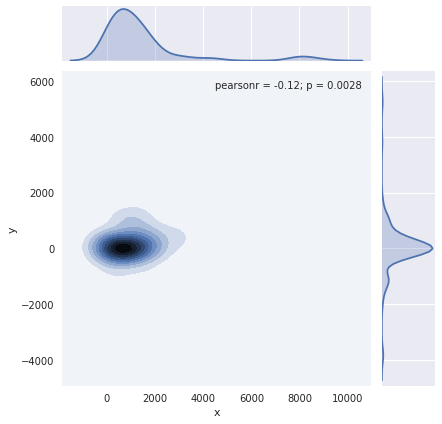

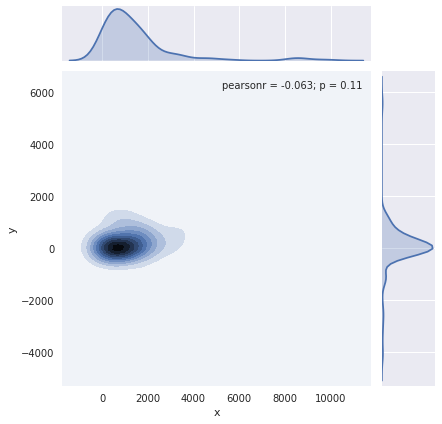

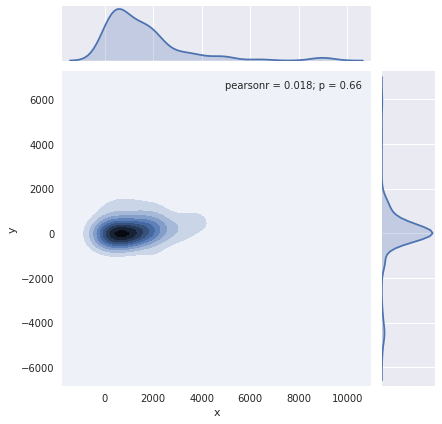

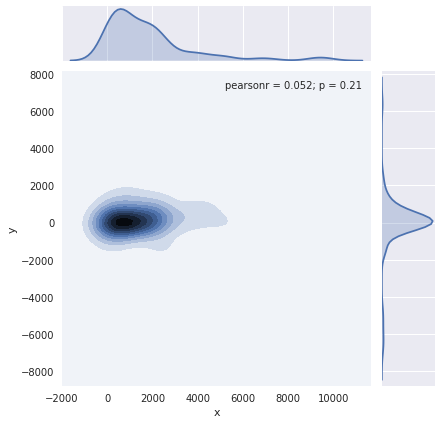

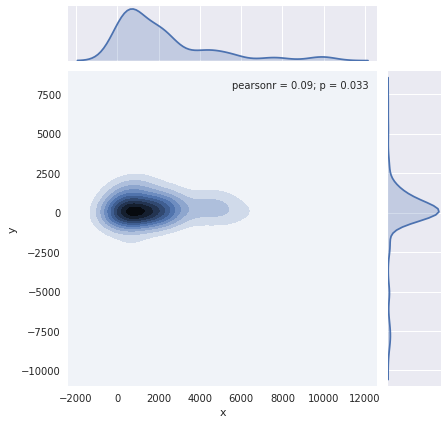

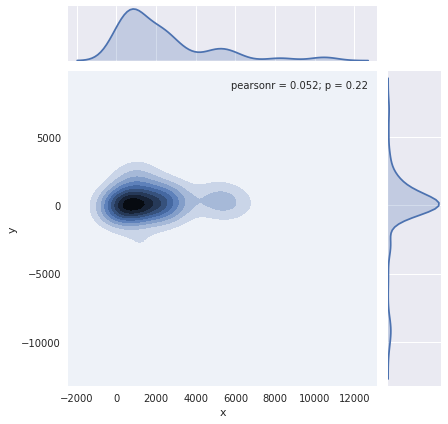

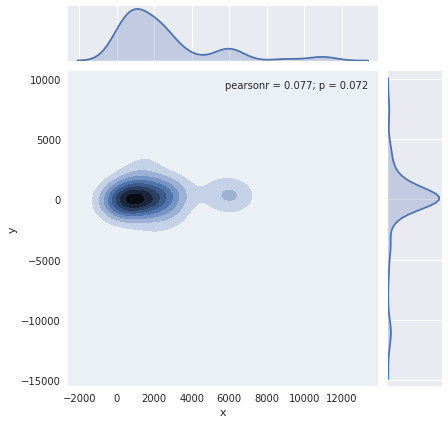

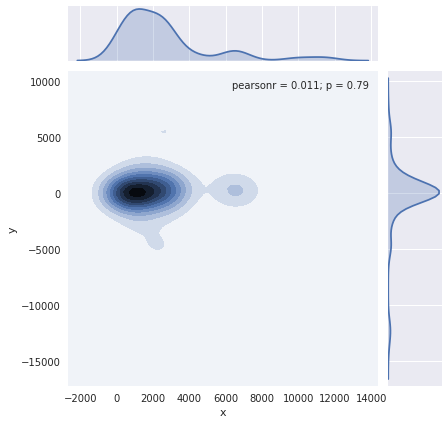

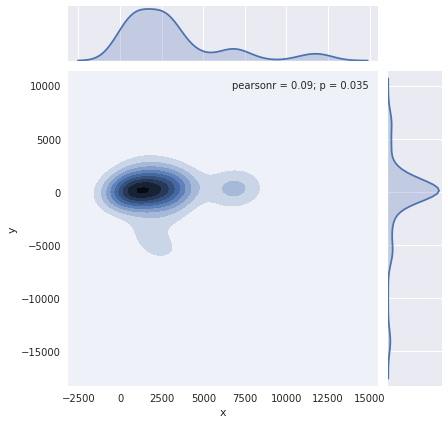

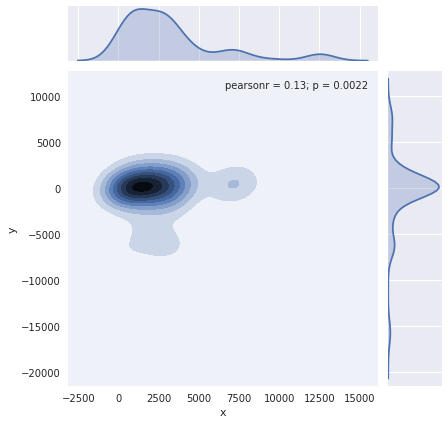

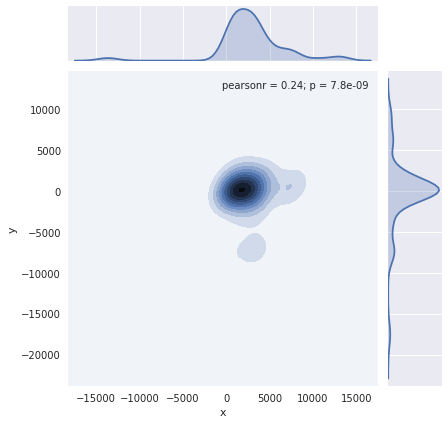

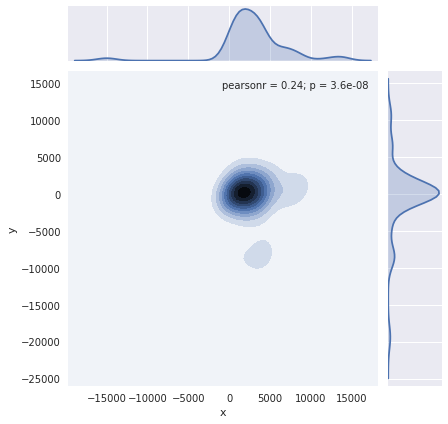

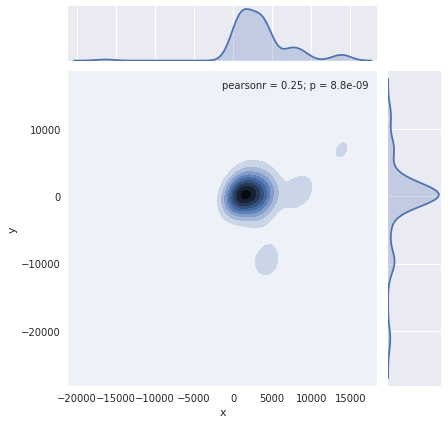

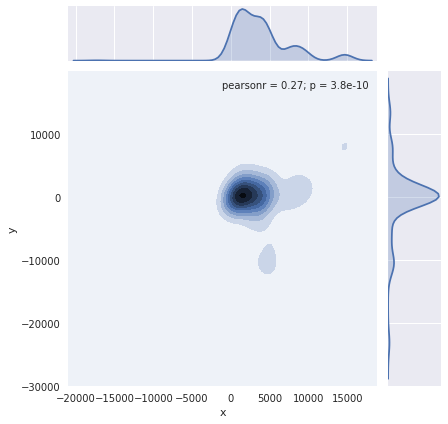

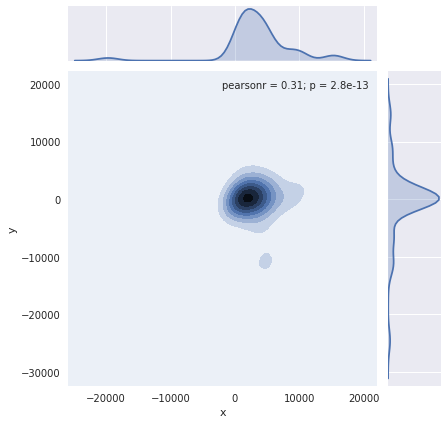

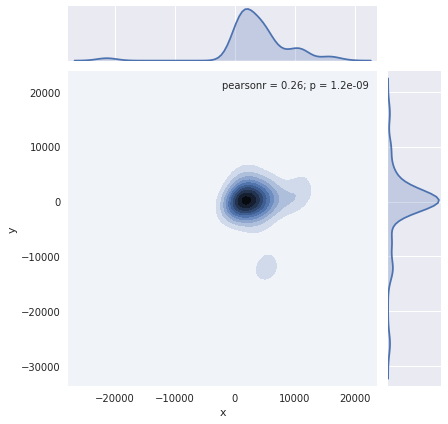

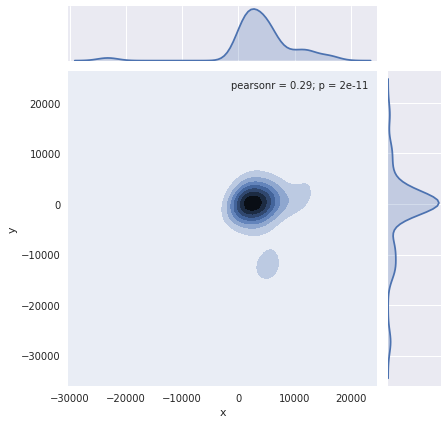

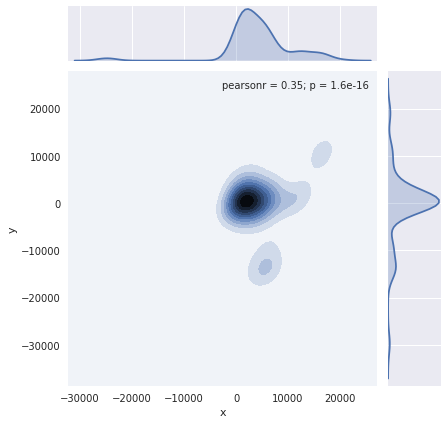

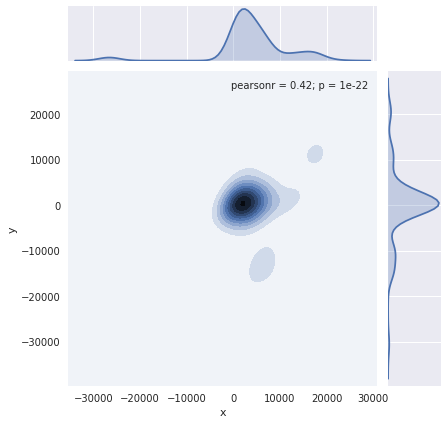

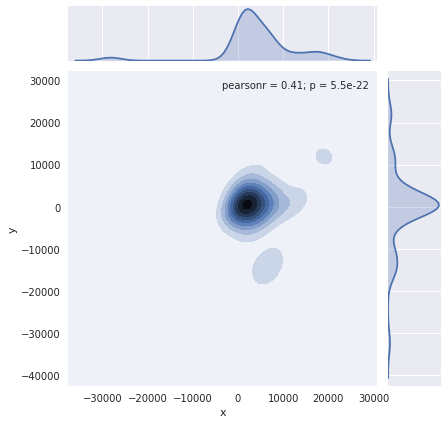

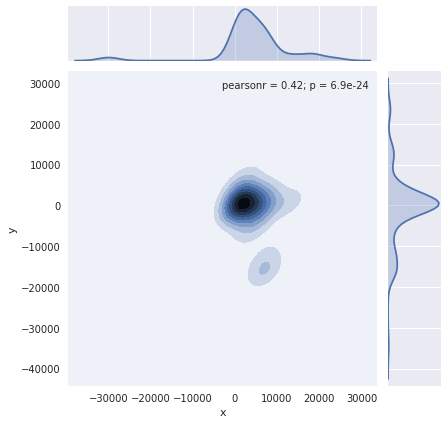

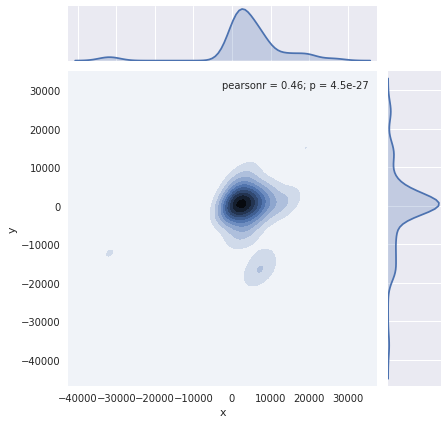

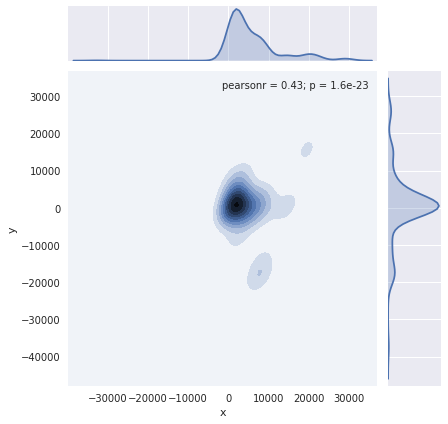

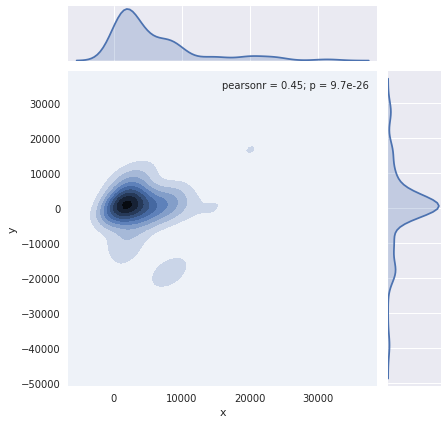

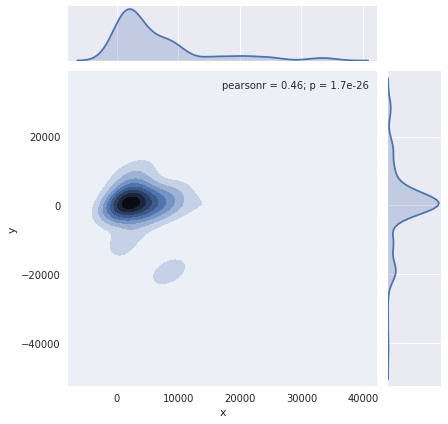

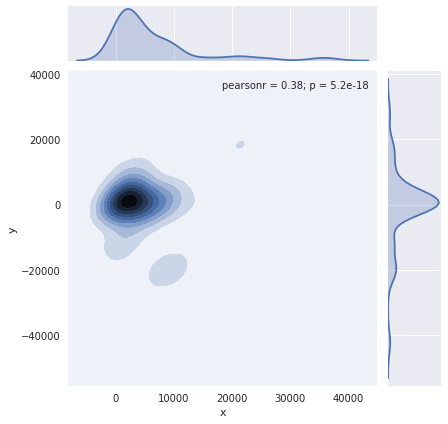

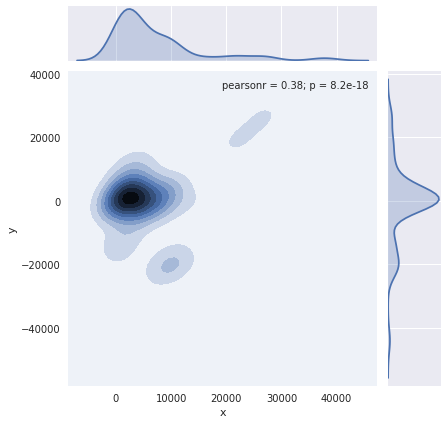

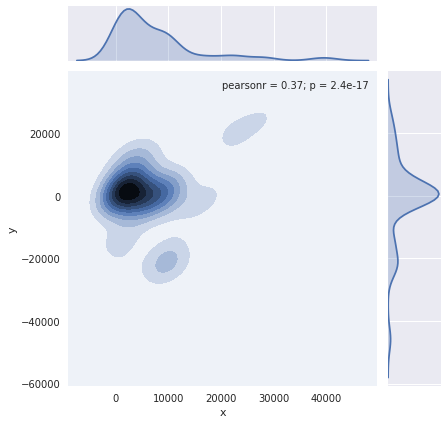

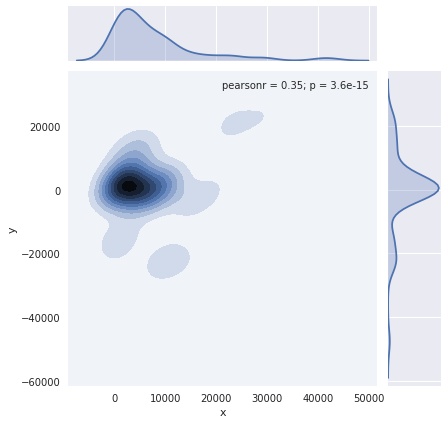

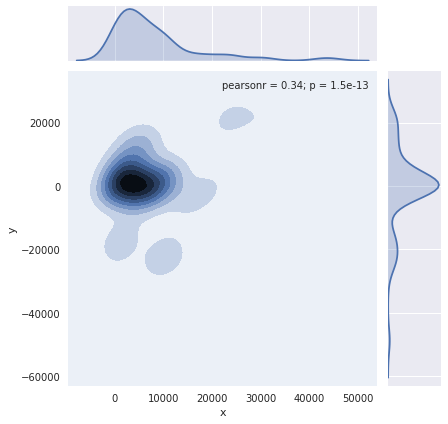

In [32]:
df = pd.DataFrame()

l = sorted(list(set([int(i.strip('_cte')) for i in bin_dp_df.keys() if '_cte' in i])))
for k in l:
    df['y'] = bin_dp_df[str(k)+'_cte'][:1000]
    df['x'] = bin_dp_df[str(k)+'_ate'][:1000]

    # sns.set(rc={'figure.figsize':(50,50)})
    sns.jointplot(x="x", y="y",data=df, kind="kde")#, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2))
    plt.show()

In [55]:
d = sorted(list(set([int(i.strip('_lat')) for i in bin_c_df.keys() if '_lat' in i])))

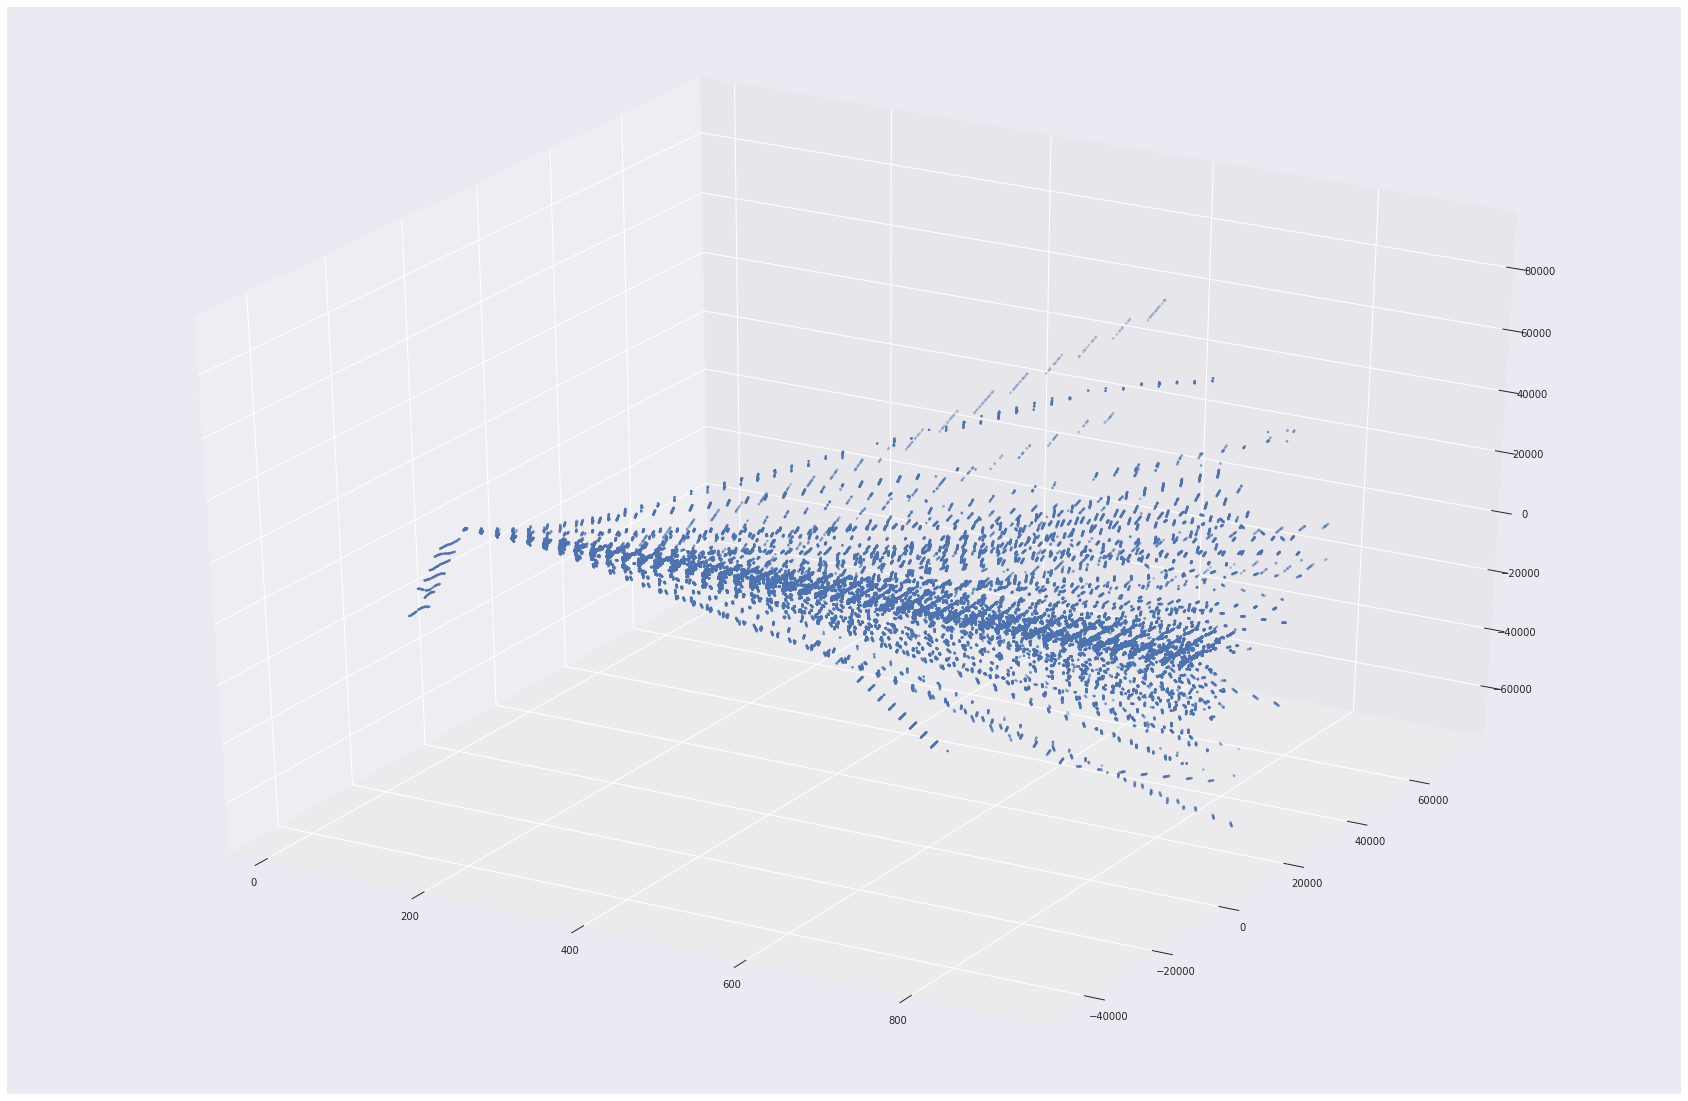

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection='3d')

l = sorted(list(set([int(i.strip('_cte')) for i in bin_dp_df.keys() if '_cte' in i])))
for k in l:
    y = bin_dp_df[str(k)+'_ate'][:5000]
    x = bin_dp_df[str(k)+'_cte'][:5000]
    z = [k] * len(y)
    ax.scatter(z,y,x,s=5, c='b', depthshade=True)
    
plt.show()

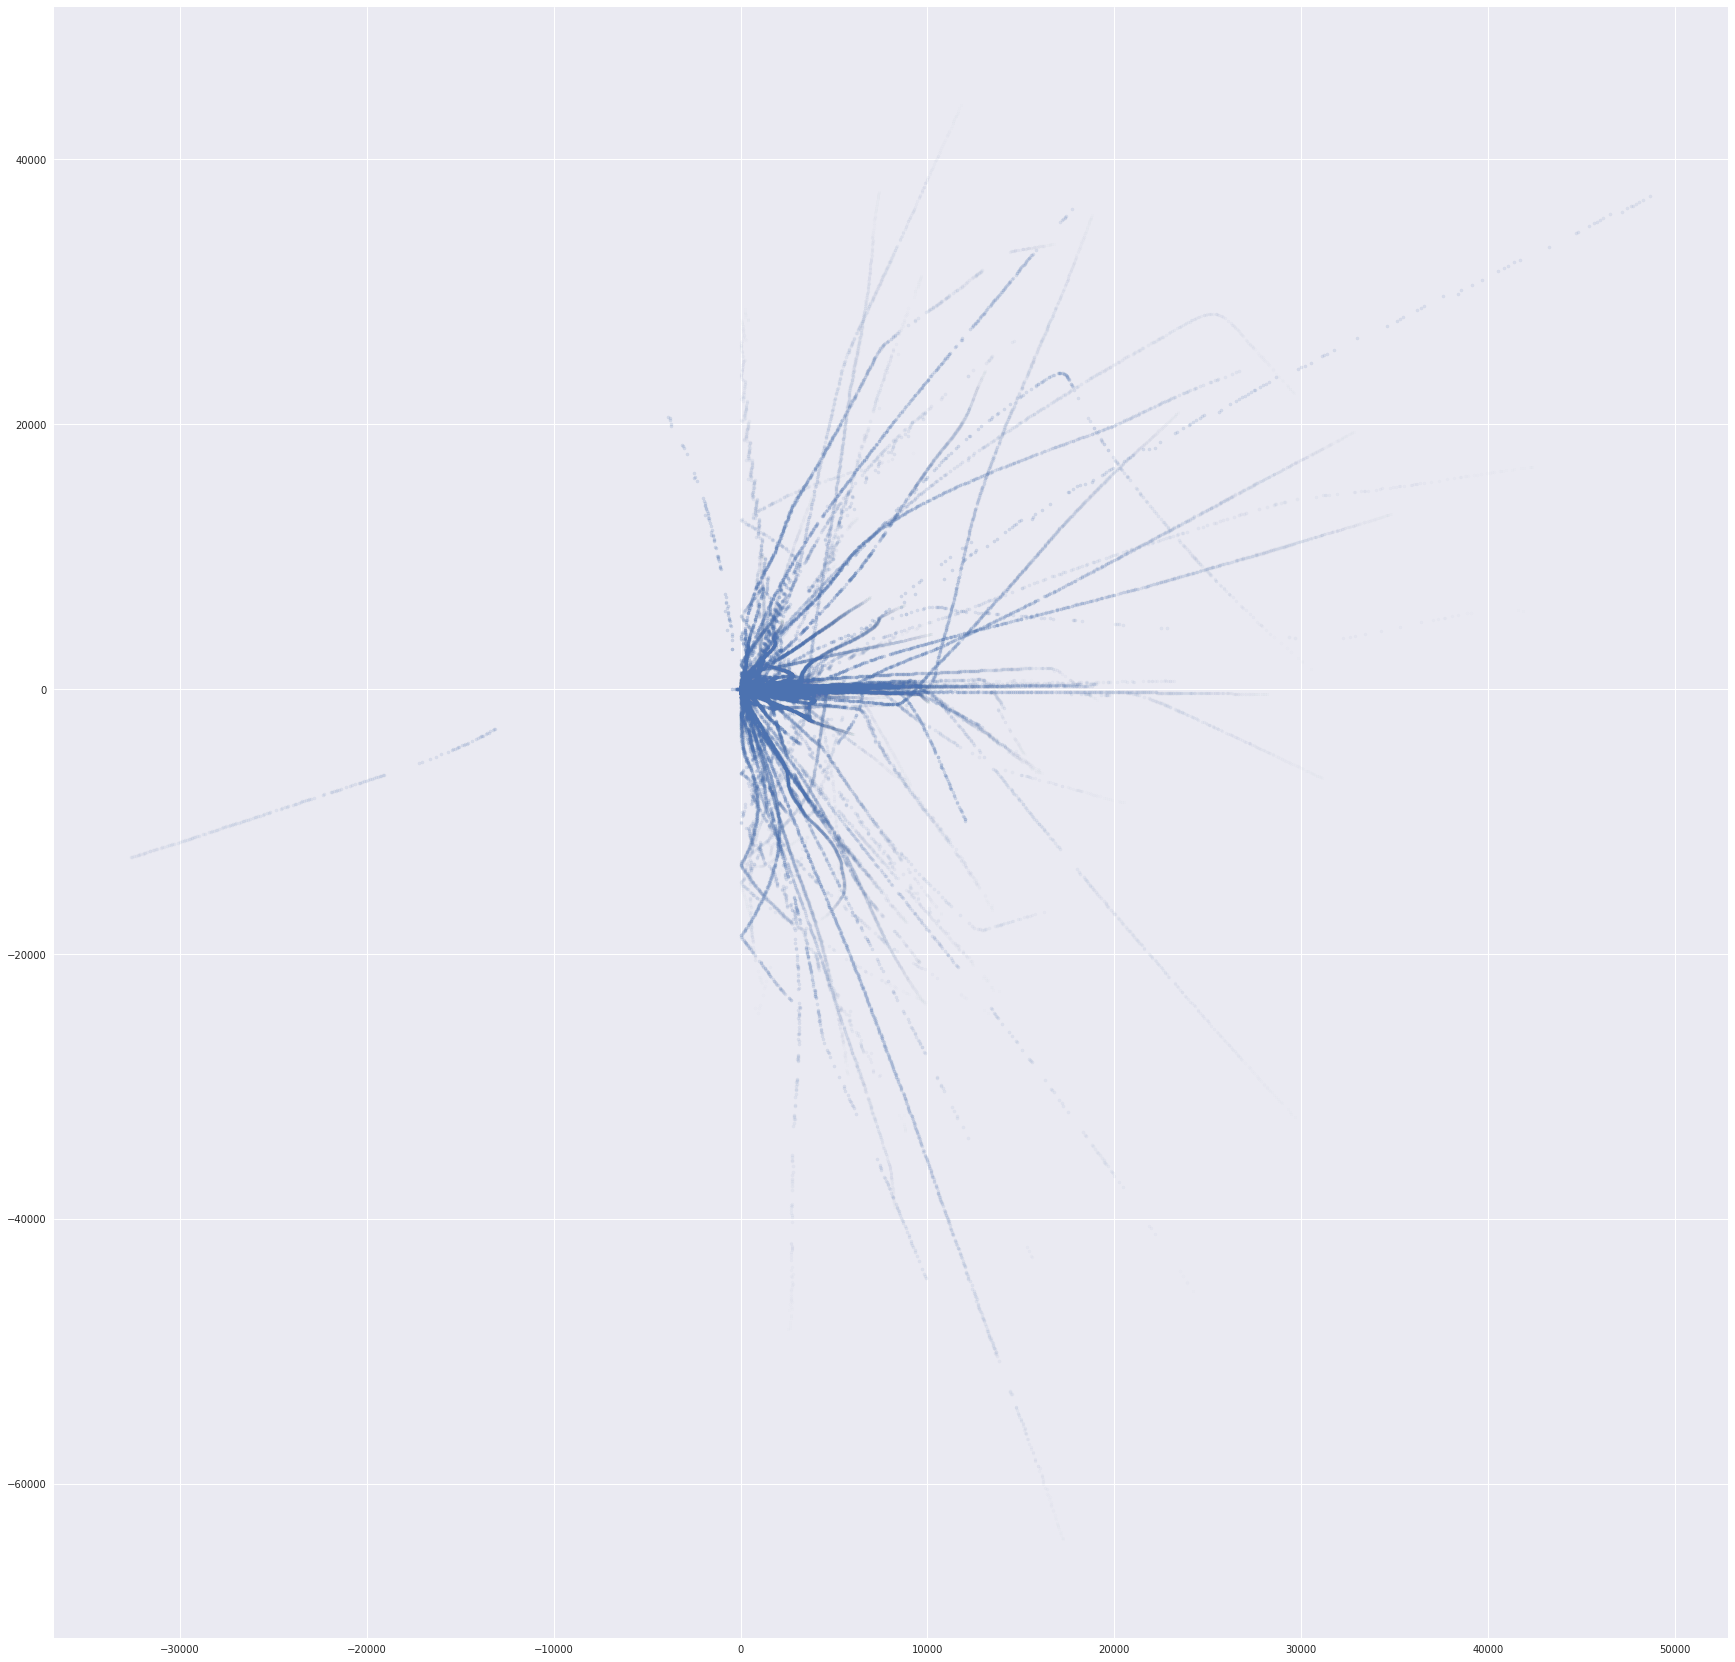

In [7]:
plt.figure(figsize=(30,30))
l = sorted(list(set([int(i.strip('_ate')) for i in bin_dp_df.keys() if '_ate' in i])))
cmap = sns.cubehelix_palette(as_cmap=True)
for k in l[::-1]:
    y = bin_dp_df[str(k)+'_cte'][:5000]
    x = bin_dp_df[str(k)+'_ate'][:5000]
    plt.scatter(x,y,s=10,c='b', alpha=(1-(k/max(l)))*0.3)
#     plt.axis((-0.2,0.2,-0.2,0.2))
    
plt.show()

A test for normal distribution is performed on the different bins with projections between certain look-ahead times. 

In [40]:
for k in bin_c_df.keys():
    if '_lat' in k:
        k2, norm_p = stats.normaltest([i for i in bin_c_df[k] if not np.isnan(i)])
        a = 0 if (norm_p < 0.0001) else 1
        print(str(k)+' - '+str(a))
#     if '_lon' in k:
#         norm_p = stats.normaltest(bin_c_df[k])
#         print(str(k)+' - '+str(norm_p))
    

520_lat - 0
420_lat - 0
360_lat - 0
280_lat - 0
20_lat - 0
500_lat - 0
440_lat - 0
340_lat - 0
160_lat - 0
540_lat - 0
400_lat - 0
40_lat - 0
180_lat - 0
260_lat - 0
220_lat - 0
140_lat - 0
60_lat - 0
80_lat - 0
460_lat - 0
320_lat - 0
300_lat - 0
480_lat - 0
240_lat - 0
560_lat - 0
580_lat - 0
120_lat - 0
600_lat - 0
100_lat - 0
200_lat - 0
380_lat - 0


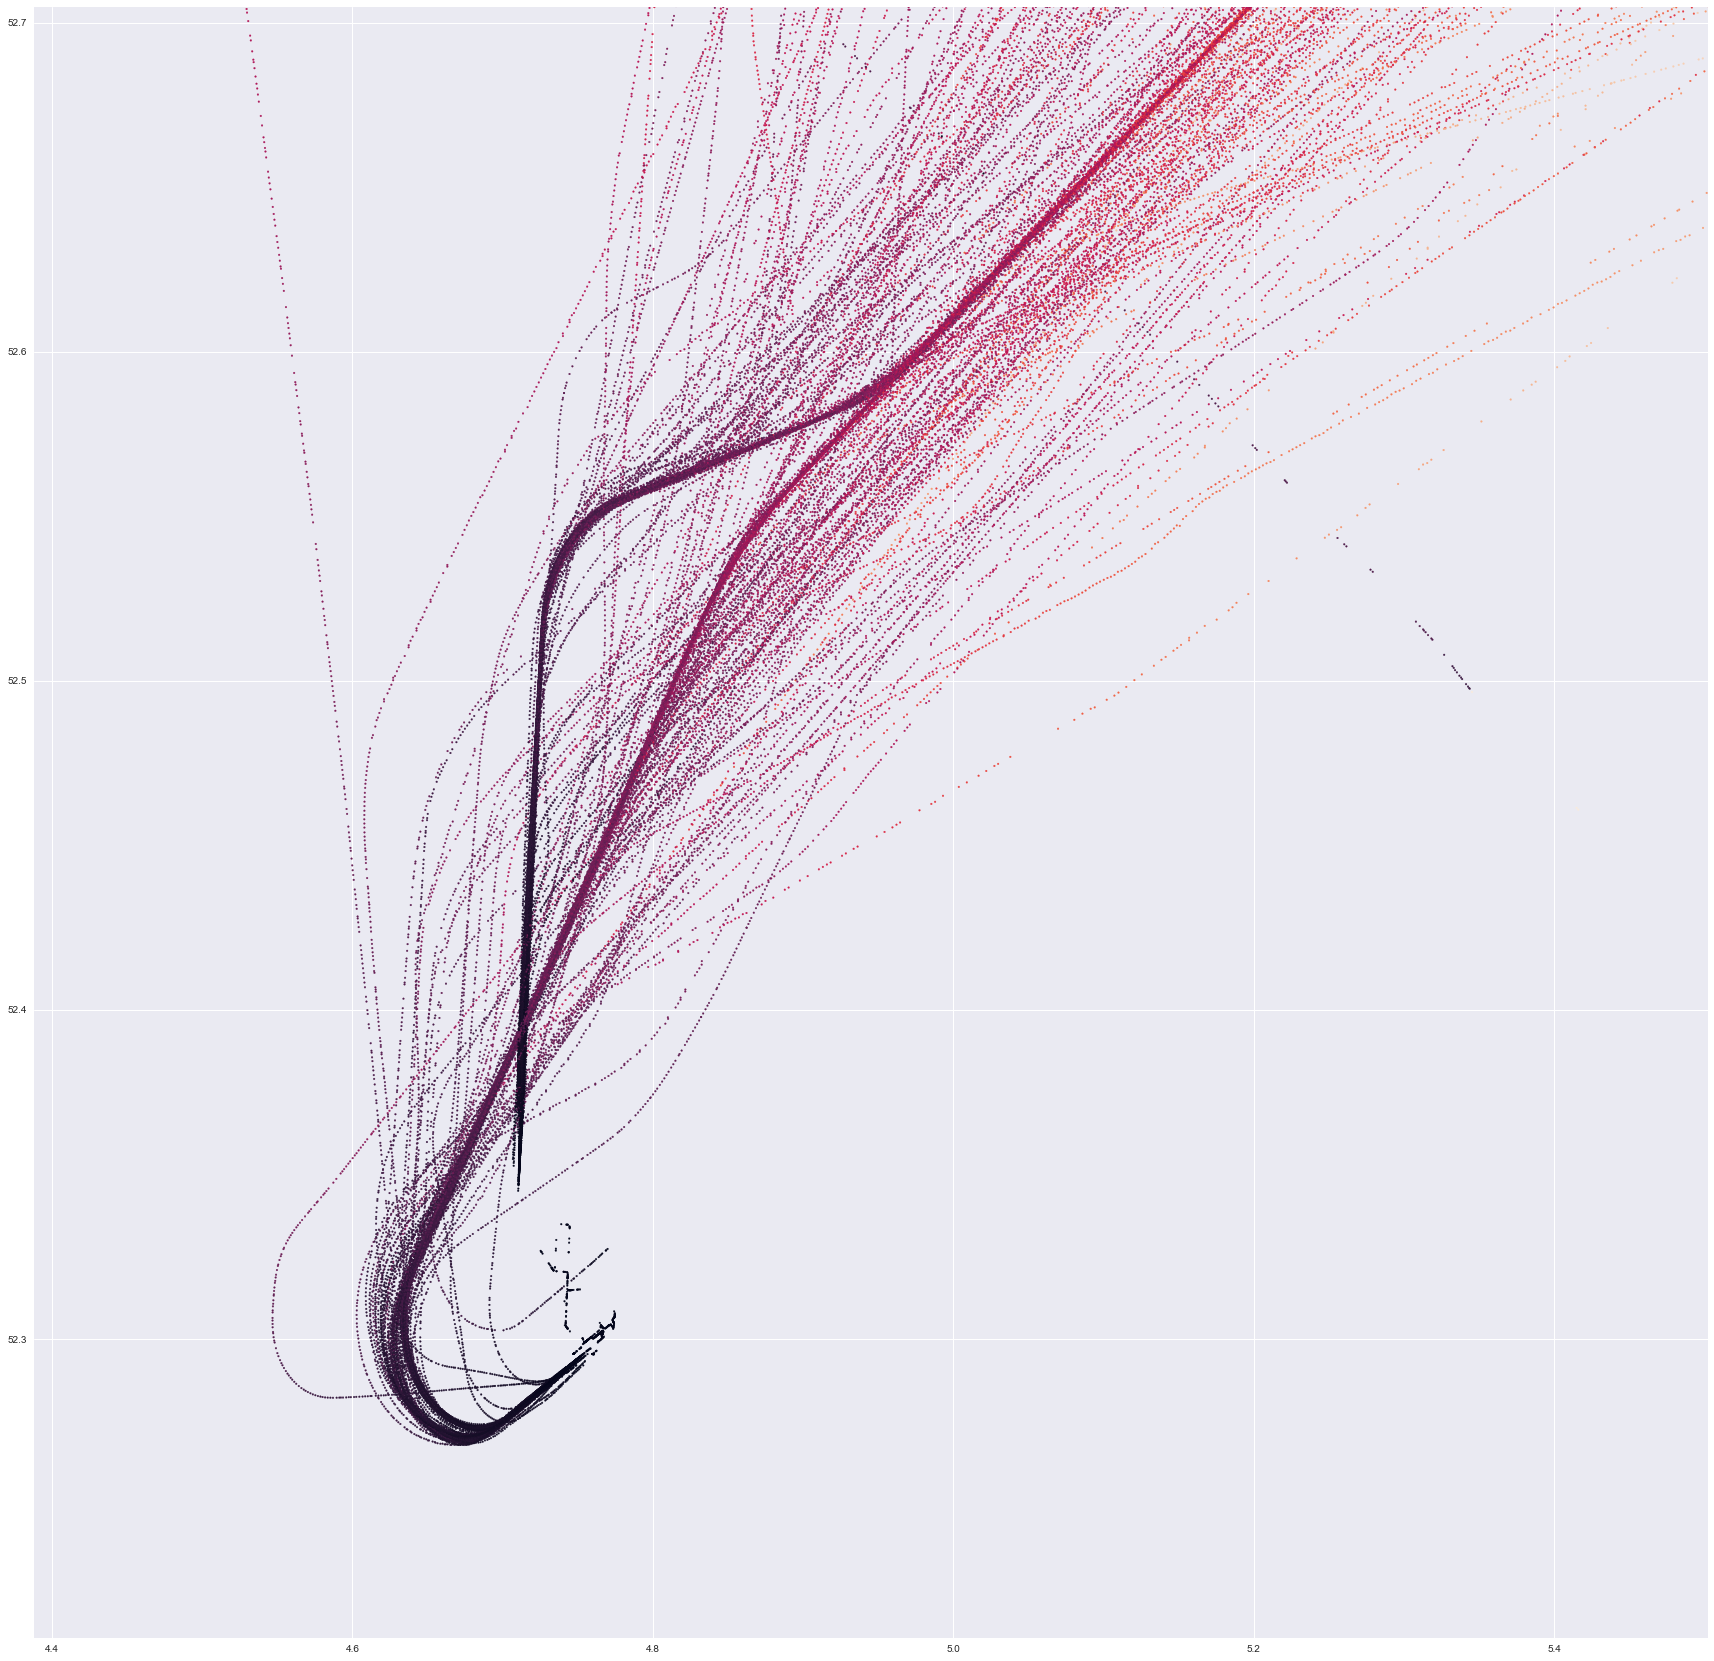

In [20]:
lat_bounds = [52.20916667, 52.70472222]
lon_bounds = [4.38777778, 5.50222222]
alt_min = 6000
plt.figure(figsize=(30,30))

a_lat = [52.7,52.8]
a_lon = [5.20,5.34]
lat_min = 52.26

fl_dict = {}
file_out = "departures.json"

for d in col.find({"$and": [{"start_lat" : {"$gt" :  lat_bounds[0], "$lt" : lat_bounds[1]}},
                            {"start_lon" : {"$gt" :  lon_bounds[0], "$lt" : lon_bounds[1]}},
                            {"alt_min" : {"$lt" : alt_min}}]}):
    df = pd.DataFrame(d)
    df = df.drop('_id', axis=1)
    if (len([i for i in df.flight_data['lat'] if a_lat[0]<i<a_lat[1]])>0) and \
        (len([i for i in df.flight_data['lon'] if a_lon[0]<i<a_lon[1]])>0) and \
        (len([i for i in df.flight_data['lat'] if i < lat_min])==0):
            
        fl_dict[df['flight_id'].iloc[0]] = df.to_dict('list')
        plt.scatter(df.flight_data['lon'],df.flight_data['lat'], c=df.flight_data['alt'], s=3)
        plt.xlim(tuple(lon_bounds))
        plt.ylim(tuple(lat_bounds))
    
plt.show()
